In [1]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns

In [34]:
big_df = pd.read_csv('laptops.csv')
big_df.head()

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [35]:
big_df.columns = big_df.columns.str.lower().str.replace(' ', '_')
list(big_df.columns)

['laptop',
 'status',
 'brand',
 'model',
 'cpu',
 'ram',
 'storage',
 'storage_type',
 'gpu',
 'screen',
 'touch',
 'final_price']

In [36]:
used_column = ['ram', 'storage', 'screen', 'final_price']
df = big_df[used_column]
df.head()

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


<Axes: xlabel='final_price', ylabel='Count'>

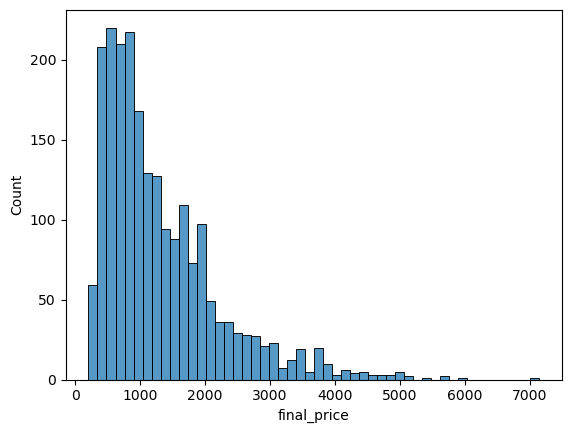

In [37]:
sns.histplot(df['final_price'], bins=50)

We see that final price tail is not that long, since most of the values are around 0 - 4000, and the last outlier is only in ~7000 values

### Counting missing values

In [38]:
missing_values = df.isnull().sum(axis = 0)
missing_values

ram            0
storage        0
screen         4
final_price    0
dtype: int64

#### Qustion 1: Screen column has missing values

In [39]:
df.median()

ram              16.000
storage         512.000
screen           15.600
final_price    1031.945
dtype: float64

#### Qustion 2: Ram column has median of 16

In [40]:
np.random.seed(42) 

#### Splitting the data

In [41]:
def split_data(df, val_size=0.2, test_size=0.2):
    n = len(df)
    
    n_val = int(n * val_size)
    n_test = int(n * test_size)
    n_train = n - n_val - n_test
    
    idx = np.arange(n)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train + n_val]]
    df_test = df.iloc[idx[n_train + n_val:]]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    return df_train, df_val, df_test

In [42]:
df_train, df_val, df_test = split_data(df=df, val_size=0.2, test_size=0.2)

In [43]:
def pull_y_out(df_train, df_val, df_test):
    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    y_test = df_test.final_price.values
    
    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']
    return y_train, y_val, y_test

In [44]:
y_train, y_val, y_test = pull_y_out(df_train, df_val, df_test)

In [45]:
df_train, y_train

(      ram  storage  screen
 0      32     1000    15.6
 1       4       64    14.1
 2      32     1000    14.0
 3      16      512    13.3
 4      32     1000    16.0
 ...   ...      ...     ...
 1291    8      256    14.0
 1292   32     1000    16.0
 1293   16      512    15.6
 1294   16      512    14.0
 1295   16      512    14.0
 
 [1296 rows x 3 columns],
 array([1123.29,  201.05,  997.74, ..., 1059.  , 1671.  , 1056.  ]))

## Preparing the data

In [46]:
mean_screen = float(df_train['screen'].mean())
mean_screen

15.163534416086618

In [47]:
df_train.isnull().sum(axis = 0)

ram        0
storage    0
screen     3
dtype: int64

In [48]:
def prepare_X_zeros(df):
    df = df.copy()
    df['screen'] = df['screen'].fillna(0)
    X = df.values
    return X

def prepare_X_mean(df):
    df = df.copy()
    df['screen'] = df['screen'].fillna(mean_screen)
    X = df.values
    return X

## Training the model

In [49]:
def rmse(y, y_pred):
	se = (y-y_pred) ** 2
	mse = se.mean()
	return float(np.sqrt(mse))

In [50]:
def train_linear_regression(X, y):
	ones = np.ones(X.shape[0])
	X = np.column_stack([ones, X])
	
	XTX = X.T.dot(X)
	XTX_inv = np.linalg.inv(XTX)
	w = XTX_inv.dot(X.T).dot(y)
	
	return w[0], w[1:]

In [51]:
X_train = prepare_X_zeros(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X_zeros(df_val)
y_pred = w0 + X_val.dot(w)

zeros_rmse = round(rmse(y_val, y_pred),2)
zeros_rmse

597.36

<Axes: ylabel='Count'>

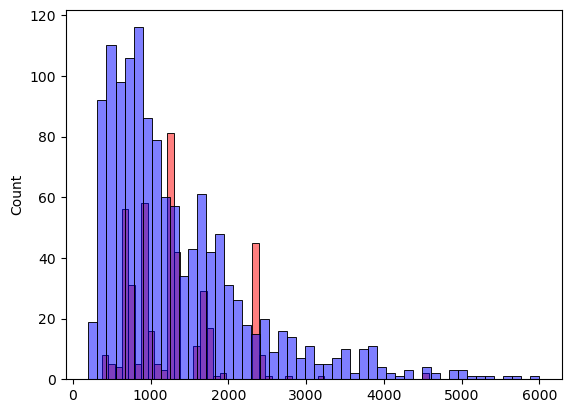

In [52]:
sns.histplot(y_pred,  bins = 50, color='red', alpha=0.5) # alpha is transparancy
sns.histplot(y_train,  bins = 50, color='blue',  alpha=0.5)#, alpha=0,5) 

In [53]:
X_train = prepare_X_mean(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X_mean(df_val)
y_pred = w0 + X_val.dot(w)

mean_rmse = round(rmse(y_val, y_pred),2)
mean_rmse

600.27

<Axes: ylabel='Count'>

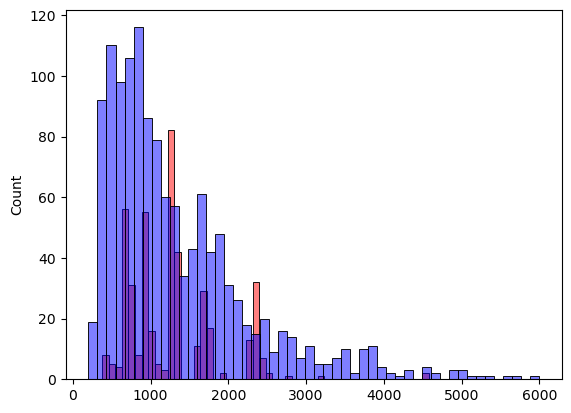

In [54]:
sns.histplot(y_pred,  bins = 50, color='red', alpha=0.5) # alpha is transparancy
sns.histplot(y_train,  bins = 50, color='blue',  alpha=0.5)#, alpha=0,5) 

#### Qustion 3: RMSE is smaller when we fill missing values with zeros

In [55]:
def train_linear_regression_reg(X, y, r):
    ones = np.ones(X.shape[0])
    X_new = np.column_stack([ones, X])
    XTX = X_new.T.dot(X_new)
    XTX = XTX + r * np.eye(XTX.shape[0])    
    
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X_new.T).dot(y)
    
    return w[0], w[1:]

In [56]:
X_train = prepare_X_zeros(df_train)
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)
    X_val = prepare_X_zeros(df_val)
    y_pred = w0 + X_val.dot(w)
    
    score = round(rmse(y_val, y_pred),2)
    print(f"r: {r}, score: {score}")

r: 0, score: 597.36
r: 0.01, score: 597.36
r: 0.1, score: 597.35
r: 1, score: 597.21
r: 5, score: 597.01
r: 10, score: 597.06
r: 100, score: 597.9


#### Qustion 4: Optimal r is r = 5, but out of provided answers the best r is r = 10

In [57]:
res = []
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    np.random.seed(seed)
    df_train, df_val, df_test = split_data(df=df, val_size=0.2, test_size=0.2)
    y_train, y_val, y_test = pull_y_out(df_train, df_val, df_test)
    
    X_train = prepare_X_zeros(df_train)
    w0, w = train_linear_regression(X_train, y_train)
    
    X_val = prepare_X_zeros(df_val)
    y_pred = w0 + X_val.dot(w)
    
    score = round(rmse(y_val, y_pred),3)
    res.append(score)

res

[565.452,
 636.799,
 588.956,
 597.815,
 571.963,
 573.238,
 647.344,
 550.44,
 587.334,
 576.102]

In [58]:
STD = round(np.std(res),3)
STD

29.177

#### Qustion 5: std = 29.177

In [59]:
seed = 9
np.random.seed(seed)
df_train, df_val, df_test = split_data(df=df, val_size=0.2, test_size=0.2)
y_train, y_val, y_test = pull_y_out(df_train, df_val, df_test)

df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)

print(f"Full training DF size: {len(df_full_train)}")
df_full_train.head()

Full training DF size: 1728


,ram,storage,screen
0,32,1000,15.6
1,8,512,13.3
2,8,512,15.6
3,32,1000,17.3
4,16,1000,16.0


In [60]:
X_full_train = prepare_X_zeros(df_full_train)
y_full_train = np.concatenate([y_train, y_val])

w0, w = train_linear_regression_reg(X_full_train, y_full_train, r==0.001)

X_test = prepare_X_zeros(df_test)
y_pred = w0 + X_test.dot(w)

score = round(rmse(y_test, y_pred),3)
score

608.61

#### Qustion 6: RMSE = 608.61

In [61]:
print(np.__version__)

1.26.4


In [62]:
import sys
print(sys.version)

3.11.10 (main, Oct  3 2024, 07:29:13) [GCC 11.2.0]
